第1轮平均loss:0.238261
本次预测集中共有110个正样本，90个负样本
正确预测个数：136, 正确率：0.680000
第2轮平均loss:0.215006
本次预测集中共有94个正样本，106个负样本
正确预测个数：156, 正确率：0.780000
第3轮平均loss:0.196891
本次预测集中共有97个正样本，103个负样本
正确预测个数：163, 正确率：0.815000
第4轮平均loss:0.172172
本次预测集中共有96个正样本，104个负样本
正确预测个数：175, 正确率：0.875000
第5轮平均loss:0.142870
本次预测集中共有100个正样本，100个负样本
正确预测个数：183, 正确率：0.915000
第6轮平均loss:0.115200
本次预测集中共有105个正样本，95个负样本
正确预测个数：198, 正确率：0.990000
第7轮平均loss:0.087945
本次预测集中共有94个正样本，106个负样本
正确预测个数：199, 正确率：0.995000
第8轮平均loss:0.065102
本次预测集中共有87个正样本，113个负样本
正确预测个数：200, 正确率：1.000000
第9轮平均loss:0.049389
本次预测集中共有92个正样本，108个负样本
正确预测个数：200, 正确率：1.000000
第10轮平均loss:0.034195
本次预测集中共有92个正样本，108个负样本
正确预测个数：200, 正确率：1.000000
第11轮平均loss:0.025291
本次预测集中共有96个正样本，104个负样本
正确预测个数：200, 正确率：1.000000
第12轮平均loss:0.019525
本次预测集中共有100个正样本，100个负样本
正确预测个数：200, 正确率：1.000000
第13轮平均loss:0.015766
本次预测集中共有99个正样本，101个负样本
正确预测个数：200, 正确率：1.000000
第14轮平均loss:0.012621
本次预测集中共有92个正样本，108个负样本
正确预测个数：200, 正确率：1.000000
第15轮平均loss:0.010204
本次预测集中共有106个正样本，94个负样本
正确预测个数：200, 

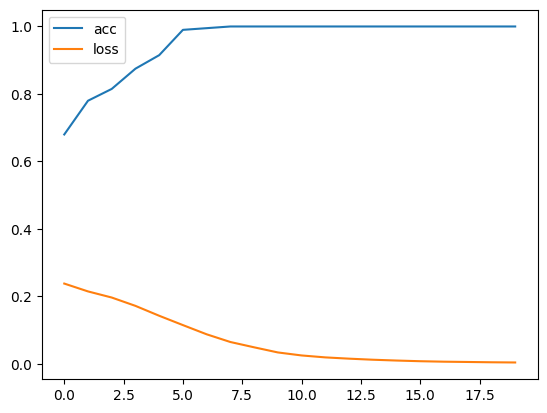

输入：fnvfee, 预测类别：0, 概率值：0.058513
输入：wzsdfg, 预测类别：0, 概率值：0.065803
输入：rqwdeg, 预测类别：0, 概率值：0.058282
输入：nakwww, 预测类别：1, 概率值：0.900742


In [ ]:
#coding:utf8

import torch
import torch.nn as nn
import numpy as np
import random
import json
import matplotlib.pyplot as plt

"""

基于pytorch的网络编写
实现一个网络完成一个简单nlp任务
判断文本中是否有某些特定字符出现

"""

class TorchModel(nn.Module):
    def __init__(self, vector_dim, sentence_length, vocab):
        super(TorchModel, self).__init__()
        self.embedding = nn.Embedding(len(vocab), vector_dim)  #embedding层
        self.pool = nn.AvgPool1d(sentence_length)   #池化层
        self.classify = nn.Linear(vector_dim, 1)     #线性层
        self.activation = torch.sigmoid     #sigmoid归一化函数
        self.loss = nn.functional.mse_loss  #loss函数采用均方差损失

    #当输入真实标签，返回loss值；无真实标签，返回预测值
    def forward(self, x, y=None):
        x = self.embedding(x)                      #(batch_size, sen_len) -> (batch_size, sen_len, vector_dim)
        x = x.transpose(1, 2)                      #(batch_size, sen_len, vector_dim) -> (batch_size, vector_dim, sen_len)
        x = self.pool(x)                           #(batch_size, vector_dim, sen_len)->(batch_size, vector_dim, 1)
        x = x.squeeze()                            #(batch_size, vector_dim, 1) -> (batch_size, vector_dim)
        x = self.classify(x)                       #(batch_size, vector_dim) -> (batch_size, 1) 3*5 5*1 -> 3*1
        y_pred = self.activation(x)                #(batch_size, 1) -> (batch_size, 1)
        if y is not None:
            return self.loss(y_pred, y)   #预测值和真实值计算损失
        else:
            return y_pred                 #输出预测结果

#字符集随便挑了一些字，实际上还可以扩充
#为每个字生成一个标号
#{"a":1, "b":2, "c":3...}
#abc -> [1,2,3]
def build_vocab():
    chars = "abcdefghijklmnopqrstuvwxyz"  #字符集
    vocab = {"pad":0}
    for index, char in enumerate(chars):
        vocab[char] = index+1   #每个字对应一个序号
    vocab['unk'] = len(vocab) #26
    return vocab

#随机生成一个样本
#从所有字中选取sentence_length个字
#反之为负样本
def build_sample(vocab, sentence_length):
    #随机从字表选取sentence_length个字，可能重复
    x = [random.choice(list(vocab.keys())) for _ in range(sentence_length)]
    #指定哪些字出现时为正样本
    if set("abc") & set(x):
        y = 1
    #指定字都未出现，则为负样本
    else:
        y = 0
    x = [vocab.get(word, vocab['unk']) for word in x]   #将字转换成序号，为了做embedding
    return x, y

#建立数据集
#输入需要的样本数量。需要多少生成多少
def build_dataset(sample_length, vocab, sentence_length):
    dataset_x = []
    dataset_y = []
    for i in range(sample_length):
        x, y = build_sample(vocab, sentence_length)
        dataset_x.append(x)
        dataset_y.append([y])
    return torch.LongTensor(dataset_x), torch.FloatTensor(dataset_y)

#建立模型
def build_model(vocab, char_dim, sentence_length):
    model = TorchModel(char_dim, sentence_length, vocab)
    return model

#测试代码
#用来测试每轮模型的准确率
def evaluate(model, vocab, sample_length):
    model.eval()
    x, y = build_dataset(200, vocab, sample_length)   #建立200个用于测试的样本
    print("本次预测集中共有%d个正样本，%d个负样本"%(sum(y), 200 - sum(y)))
    correct, wrong = 0, 0
    with torch.no_grad():
        y_pred = model(x)      #模型预测
        for y_p, y_t in zip(y_pred, y):  #与真实标签进行对比
            if float(y_p) < 0.5 and int(y_t) == 0:
                correct += 1   #负样本判断正确
            elif float(y_p) >= 0.5 and int(y_t) == 1:
                correct += 1   #正样本判断正确
            else:
                wrong += 1
    print("正确预测个数：%d, 正确率：%f"%(correct, correct/(correct+wrong)))
    return correct/(correct+wrong)


def main():
    #配置参数
    epoch_num = 20        #训练轮数
    batch_size = 20       #每次训练样本个数
    train_sample = 500    #每轮训练总共训练的样本总数
    char_dim = 20         #每个字的维度
    sentence_length = 6   #样本文本长度
    learning_rate = 0.005 #学习率
    # 建立字表
    vocab = build_vocab()
    # 建立模型
    model = build_model(vocab, char_dim, sentence_length)
    # 选择优化器
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    log = []
    # 训练过程
    for epoch in range(epoch_num):
        model.train()
        watch_loss = []
        for batch in range(int(train_sample / batch_size)):
            x, y = build_dataset(batch_size, vocab, sentence_length) #构造一组训练样本
            optim.zero_grad()    #梯度归零
            loss = model(x, y)   #计算loss
            loss.backward()      #计算梯度
            optim.step()         #更新权重
            watch_loss.append(loss.item())
        print("=========\n第%d轮平均loss:%f" % (epoch + 1, np.mean(watch_loss)))
        acc = evaluate(model, vocab, sentence_length)   #测试本轮模型结果
        log.append([acc, np.mean(watch_loss)])
    #画图
    plt.plot(range(len(log)), [l[0] for l in log], label="acc")  #画acc曲线
    plt.plot(range(len(log)), [l[1] for l in log], label="loss")  #画loss曲线
    plt.legend()
    plt.show()
    #保存模型
    torch.save(model.state_dict(), "model.pth")
    # 保存词表
    writer = open("vocab.json", "w", encoding="utf8")
    writer.write(json.dumps(vocab, ensure_ascii=False, indent=2))
    writer.close()
    return

#使用训练好的模型做预测
def predict(model_path, vocab_path, input_strings):
    char_dim = 20  # 每个字的维度
    sentence_length = 6  # 样本文本长度
    vocab = json.load(open(vocab_path, "r", encoding="utf8")) #加载字符表
    model = build_model(vocab, char_dim, sentence_length)     #建立模型
    model.load_state_dict(torch.load(model_path))             #加载训练好的权重
    x = []
    for input_string in input_strings:
        x.append([vocab[char] for char in input_string])  #将输入序列化
    model.eval()   #测试模式
    with torch.no_grad():  #不计算梯度
        result = model.forward(torch.LongTensor(x))  #模型预测
    for i, input_string in enumerate(input_strings):
        print("输入：%s, 预测类别：%d, 概率值：%f" % (input_string, round(float(result[i])), result[i])) #打印结果



if __name__ == "__main__":
    main()
    test_strings = ["fnvfee", "wzsdfg", "rqwdeg", "nakwww"]
    predict("model.pth", "vocab.json", test_strings)


第1轮平均loss:0.210881
本次预测集中共有106个正样本，94个负样本
正确预测个数：178, 正确率：0.890000
第2轮平均loss:0.075807
本次预测集中共有91个正样本，109个负样本
正确预测个数：200, 正确率：1.000000
第3轮平均loss:0.015055
本次预测集中共有85个正样本，115个负样本
正确预测个数：200, 正确率：1.000000
第4轮平均loss:0.002674
本次预测集中共有94个正样本，106个负样本
正确预测个数：200, 正确率：1.000000
第5轮平均loss:0.001345
本次预测集中共有106个正样本，94个负样本
正确预测个数：200, 正确率：1.000000
第6轮平均loss:0.000631
本次预测集中共有95个正样本，105个负样本
正确预测个数：200, 正确率：1.000000
第7轮平均loss:0.000427
本次预测集中共有114个正样本，86个负样本
正确预测个数：200, 正确率：1.000000
第8轮平均loss:0.000318
本次预测集中共有104个正样本，96个负样本
正确预测个数：200, 正确率：1.000000
第9轮平均loss:0.000273
本次预测集中共有100个正样本，100个负样本
正确预测个数：200, 正确率：1.000000
第10轮平均loss:0.000210
本次预测集中共有103个正样本，97个负样本
正确预测个数：200, 正确率：1.000000
第11轮平均loss:0.000193
本次预测集中共有101个正样本，99个负样本
正确预测个数：200, 正确率：1.000000
第12轮平均loss:0.000145
本次预测集中共有100个正样本，100个负样本
正确预测个数：200, 正确率：1.000000
第13轮平均loss:0.000140
本次预测集中共有107个正样本，93个负样本
正确预测个数：200, 正确率：1.000000
第14轮平均loss:0.000119
本次预测集中共有98个正样本，102个负样本
正确预测个数：200, 正确率：1.000000
第15轮平均loss:0.000093
本次预测集中共有91个正样本，109个负样本
正确预测个数：200, 

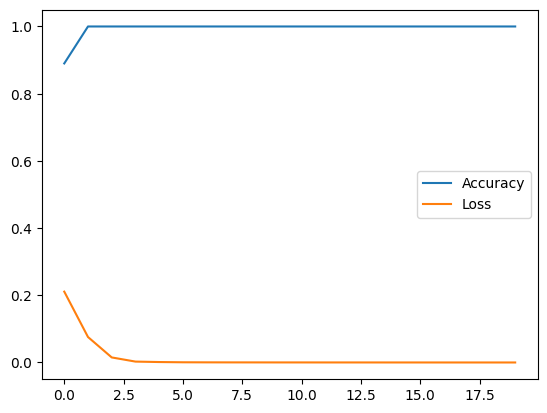

输入：fnvfee, 预测类别：0, 概率值：0.008900
输入：wzsdfg, 预测类别：0, 概率值：0.005968
输入：rqwdeg, 预测类别：0, 概率值：0.006770
输入：nakwww, 预测类别：1, 概率值：0.999751


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random
import json
import matplotlib.pyplot as plt

class TorchModel(nn.Module):
    def __init__(self, vector_dim, sentence_length, vocab):
        super(TorchModel, self).__init__()
        self.embedding = nn.Embedding(len(vocab), vector_dim)
        self.conv1 = nn.Conv1d(vector_dim, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(sentence_length)
        self.fc = nn.Linear(32, 1)
        self.activation = torch.sigmoid
        self.loss = nn.functional.mse_loss

    def forward(self, x, y=None):
        x = self.embedding(x)
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.pool(x)
        x = x.view(-1, 32)
        x = self.fc(x)
        y_pred = self.activation(x)
        if y is not None:
            return self.loss(y_pred, y)
        else:
            return y_pred

def build_vocab():
    chars = "abcdefghijklmnopqrstuvwxyz"
    vocab = {"pad": 0}
    for index, char in enumerate(chars):
        vocab[char] = index + 1
    vocab['unk'] = len(vocab)
    return vocab

def build_sample(vocab, sentence_length):
    x = [random.choice(list(vocab.keys())) for _ in range(sentence_length)]
    if set("abc") & set(x):
        y = 1
    else:
        y = 0
    x = [vocab.get(word, vocab['unk']) for word in x]
    return x, y

def build_dataset(sample_length, vocab, sentence_length):
    dataset_x = []
    dataset_y = []
    for i in range(sample_length):
        x, y = build_sample(vocab, sentence_length)
        dataset_x.append(x)
        dataset_y.append([y])
    return torch.LongTensor(dataset_x), torch.FloatTensor(dataset_y)

def build_model(vocab, char_dim, sentence_length):
    model = TorchModel(char_dim, sentence_length, vocab)
    return model

def evaluate(model, vocab, sample_length):
    model.eval()
    x, y = build_dataset(200, vocab, sample_length)
    print("本次预测集中共有%d个正样本，%d个负样本" % (sum(y), 200 - sum(y)))
    correct, wrong = 0, 0
    with torch.no_grad():
        y_pred = model(x)
        for y_p, y_t in zip(y_pred, y):
            if float(y_p) < 0.5 and int(y_t) == 0:
                correct += 1
            elif float(y_p) >= 0.5 and int(y_t) == 1:
                correct += 1
            else:
                wrong += 1
    print("正确预测个数：%d, 正确率：%f" % (correct, correct / (correct + wrong)))
    return correct / (correct + wrong)

def main():
    epoch_num = 20
    batch_size = 20
    train_sample = 500
    char_dim = 20
    sentence_length = 6
    learning_rate = 0.005
    vocab = build_vocab()
    model = build_model(vocab, char_dim, sentence_length)
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    log = []
    for epoch in range(epoch_num):
        model.train()
        watch_loss = []
        for batch in range(int(train_sample / batch_size)):
            x, y = build_dataset(batch_size, vocab, sentence_length)
            optim.zero_grad()
            loss = model(x, y)
            loss.backward()
            optim.step()
            watch_loss.append(loss.item())
        print("=========\n第%d轮平均loss:%f" % (epoch + 1, np.mean(watch_loss)))
        acc = evaluate(model, vocab, sentence_length)
        log.append([acc, np.mean(watch_loss)])
    plt.plot(range(len(log)), [l[0] for l in log], label="Accuracy")
    plt.plot(range(len(log)), [l[1] for l in log], label="Loss")
    plt.legend()
    plt.show()
    torch.save(model.state_dict(), "model_cnn.pth")
    writer = open("vocab_cnn.json", "w", encoding="utf8")
    writer.write(json.dumps(vocab, ensure_ascii=False, indent=2))
    writer.close()
    return

def predict(model_path, vocab_path, input_strings):
    char_dim = 20
    sentence_length = 6
    vocab = json.load(open(vocab_path, "r", encoding="utf8"))
    model = build_model(vocab, char_dim, sentence_length)
    model.load_state_dict(torch.load(model_path))
    x = []
    for input_string in input_strings:
        x.append([vocab[char] for char in input_string])
    model.eval()
    with torch.no_grad():
        result = model.forward(torch.LongTensor(x))
    for i, input_string in enumerate(input_strings):
        print("输入：%s, 预测类别：%d, 概率值：%f" % (input_string, round(float(result[i])), result[i]))

if __name__ == "__main__":
    main()
    test_strings = ["fnvfee", "wzsdfg", "rqwdeg", "nakwww"]
    predict("model_cnn.pth", "vocab_cnn.json", test_strings)
